## Setup

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs, make_circles

from multipledispatch import dispatch

In [16]:
ryg_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [17]:
np.random.seed(0)

## Generate data

In [18]:
#data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
data, labels = make_circles(n_samples=1000, random_state=0, noise=0.2, factor=0.3)
print(data.shape, labels.shape)

(1000, 2) (1000,)


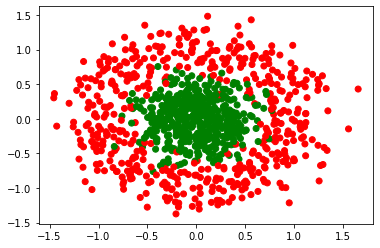

In [19]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=ryg_cmap)
plt.show()

In [20]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

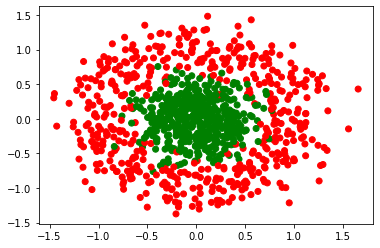

In [21]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=ryg_cmap)
plt.show()

## Multi class classification

In [22]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [23]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 2) (250, 2)


In [10]:
def random(rows, cols):
    return (np.random.randn(rows,cols),np.random.randn(1,cols))

In [11]:
def zeroes(rows, cols):
    return (np.zeros(rows,cols), np.zeros(1,cols))

In [12]:
def xavier(rows, cols):
    return (np.random.randn(rows,cols)*np.sqrt(1/rows), np.random.randn(1,cols))

In [13]:
def he(rows, cols):
    return (np.random.randn(rows,cols)*np.sqrt(2/rows),np.random.randn(1,cols))

In [14]:
def softmax(X):
    exps = np.exp(X, dtype=np.float128)
    return exps / np.sum(exps, axis=1).reshape(-1,1)

In [15]:
def grad_ce_softmax(PRED, ACTUAL):
    return PRED - ACTUAL
    

In [16]:
def update_weights(params, param, value):
    params[param] -= value
    

In [17]:
class SigmoidActivator:
    
    def forward_activate(self,X): 
        return 1.0/(1.0 + np.exp(-X))
    
    def backward_activate(self,X):
        return X*(1-X) 

 

In [18]:
class ReluActivator:
    
    def forward_activate(self,X): 
        return np.maximum(0,X)
    
    def backward_activate(self,X):
        return 1.0*(X>0) 

 

In [19]:
class LeakyReluActivator:
    
    def __init__(self, leaky_slope = 0.01):
        self.leaky_slope = leaky_slope
    
    def forward_activate(self,X): 
        return np.maximum(self.leaky_slope*X,X)
    
    def backward_activate(self,X):
        d=np.zeros_like(X)
        d[X<=0]=self.leaky_slope
        d[X>0]=1
        return d

 

In [20]:
class FeedForwardNetwork:

    def __init__(self, layer_sizes, hidden_layer_activator, out_forward_activator, out_loss_grad, weight_init):
        self.params = {}
        self.layer_sizes = layer_sizes
        self.hidden_layer_activator = hidden_layer_activator
        self.out_forward_activator = out_forward_activator
        self.out_loss_grad = out_loss_grad
        self.num_layers = len(self.layer_sizes)-1
        self.gradients = {}
        self.A = {}
        self.H = {}
        np.random.seed(0)
        for i in range(1,self.num_layers+1):
            initial_weights = weight_init(self.layer_sizes[i-1],self.layer_sizes[i])
            self.params["W"+str(i)] = initial_weights[0]
            self.params["B"+str(i)] =initial_weights[1]
            #self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(2/self.layer_sizes[i-1])
            #self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])


    @dispatch(np.ndarray,dict)
    def forward_pass(self, X, parameters):
        for i in range(1,self.num_layers+1):
            pre_activation_input = X if i == 1 else self.H["H"+str(i-1)]
            self.A["A"+str(i)] = np.matmul(pre_activation_input, parameters["W"+str(i)]) + parameters["B"+str(i)]
            activation_function = self.out_forward_activator if i == self.num_layers else self.hidden_layer_activator.forward_activate
            self.H["H"+str(i)] = activation_function(self.A["A"+str(i)])
        
        return self.H["H"+str(self.num_layers)]
           
        

    @dispatch(np.ndarray)
    def forward_pass(self, X):
        return self.forward_pass(X, self.params)

    @dispatch(np.ndarray,np.ndarray,dict)
    def back_propogate(self, X, Y, parameters):
        self.forward_pass(X, parameters)
        for i in range(self.num_layers,0, -1):
            
            grad_activation = 0 if i == self.num_layers else np.matmul(self.gradients["dA"+str(i+1)], parameters["W"+str(i+1)].T) 
            self.gradients["dH"+str(i)] = grad_activation
            grad_h_activate = self.hidden_layer_activator.backward_activate
            grad_pre_activation = self.out_loss_grad(self.H["H"+str(i)], Y) if i== self.num_layers else np.multiply(self.gradients["dH"+str(i)], grad_h_activate(self.H["H"+str(i)])) 
            self.gradients["dA"+str(i)] = grad_pre_activation
            prev_weight_activation = X if i == 1 else self.H["H"+str(i-1)]
            self.gradients["dW"+str(i)] = np.matmul(prev_weight_activation.T, self.gradients["dA"+str(i)])
            self.gradients["dB"+str(i)] = np.sum(self.gradients["dA"+str(i)], axis=0).reshape(1, -1)
           
            

    @dispatch(np.ndarray,np.ndarray)
    def back_propogate(self, X, Y):
        return self.back_propogate(X, Y, self.params)


In [21]:
class GradientDescentLearner:
    
    def __init__(self, network, learning_rate):
        self.network = network
        self.learning_rate = learning_rate
        
    
    def learn(self,X, Y):
        self.network.back_propogate(X, Y)
        m = X.shape[0]
        
        for i in range(1,self.network.num_layers+1):
          update_weights(self.network.params,"W"+str(i),self.learning_rate * (self.network.gradients["dW"+str(i)]/m))
          update_weights(self.network.params,"B"+str(i),self.learning_rate * (self.network.gradients["dB"+str(i)]/m))
          

        

In [22]:
class BatchedGradientDescentLearner(GradientDescentLearner):
    
    def __init__(self,  network, learning_rate, batch_size):
        super().__init__(network, learning_rate)
        self.batch_size = batch_size
        
    def learn(self,X, Y):
        
        m = X.shape[0]
        for k in range(0,m,self.batch_size):
            self.network.back_propogate(X[k:k+self.batch_size], Y[k:k+self.batch_size])
            for i in range(1,self.network.num_layers+1):
              update_weights(self.network.params,"W"+str(i),self.learning_rate * (self.network.gradients["dW"+str(i)]/self.batch_size))
              update_weights(self.network.params,"B"+str(i),self.learning_rate * (self.network.gradients["dB"+str(i)]/self.batch_size))

                

In [23]:
class MomentumGradientDescentLearner(GradientDescentLearner):
    
    def __init__(self,  network, learning_rate, hist_decay_rate):
        super().__init__(network, learning_rate)
        self.hist_decay_rate = hist_decay_rate
        self.update_params={}
        for i in range(1,self.network.num_layers+1):
            self.update_params["v_w"+str(i)]=0
            self.update_params["v_b"+str(i)]=0
            self.update_params["m_b"+str(i)]=0
            self.update_params["m_w"+str(i)]=0

    
    def learn(self,X, Y):
        
        m = X.shape[0]
        self.network.back_propogate(X, Y)
        for i in range(1,self.network.num_layers+1):
              self.update_params["v_w"+str(i)] = self.hist_decay_rate *self.update_params["v_w"+str(i)] + self.learning_rate * (self.network.gradients["dW"+str(i)]/m)
              self.update_params["v_b"+str(i)] = self.hist_decay_rate *self.update_params["v_b"+str(i)] + self.learning_rate * (self.network.gradients["dB"+str(i)]/m)
              update_weights(self.network.params,"W"+str(i),self.update_params["v_w"+str(i)])
              update_weights(self.network.params,"B"+str(i),self.update_params["v_b"+str(i)] )



In [24]:
class NagGradientDescentLearner(MomentumGradientDescentLearner):

    def __init__(self,  network, learning_rate, hist_decay_rate):
        super().__init__(network, learning_rate, hist_decay_rate)
        self.prev_update_params={}
        for i in range(1,self.network.num_layers+1):
            self.prev_update_params["v_w"+str(i)]=0
            self.prev_update_params["v_b"+str(i)]=0

    
    def learn(self,X, Y):
        
        m = X.shape[0]
        temp_params = {}
        for i in range(1,self.network.num_layers+1):
          self.update_params["v_w"+str(i)]=self.hist_decay_rate*self.prev_update_params["v_w"+str(i)]
          self.update_params["v_b"+str(i)]=self.hist_decay_rate*self.prev_update_params["v_b"+str(i)]
          temp_params["W"+str(i)]=self.network.params["W"+str(i)]-self.update_params["v_w"+str(i)]
          temp_params["B"+str(i)]=self.network.params["B"+str(i)]-self.update_params["v_b"+str(i)]
        self.network.back_propogate(X,Y,temp_params)
        for i in range(1,self.network.num_layers+1):
          self.update_params["v_w"+str(i)] = self.hist_decay_rate *self.update_params["v_w"+str(i)] + self.learning_rate * (self.network.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = self.hist_decay_rate *self.update_params["v_b"+str(i)] + self.learning_rate * (self.network.gradients["dB"+str(i)]/m)
          update_weights(self.network.params,"W"+str(i),self.learning_rate *self.update_params["v_w"+str(i)])
          update_weights(self.network.params,"B"+str(i),self.learning_rate *self.update_params["v_b"+str(i)] )

        self.prev_update_params=self.update_params 


    

In [25]:
class AdamGradientDescentLearner(MomentumGradientDescentLearner):

    def __init__(self,  network, learning_rate, hist_decay_rate,hist_quad_decay):
        super().__init__(network, learning_rate, hist_decay_rate)
        self.hist_quad_decay = hist_quad_decay
        self.eps = 1e-8

    
    def learn(self,X, Y):
        
        m = X.shape[0]
        self.network.back_propogate(X, Y)
        num_updates=0
        for i in range(1,self.network.num_layers+1):
          num_updates+=1
          self.update_params["m_w"+str(i)]=self.hist_decay_rate*self.update_params["m_w"+str(i)]+(1-self.hist_decay_rate)*(self.network.gradients["dW"+str(i)]/m)
          self.update_params["v_w"+str(i)]=self.hist_quad_decay*self.update_params["v_w"+str(i)]+(1-self.hist_quad_decay)*((self.network.gradients["dW"+str(i)]/m)**2)
          m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(self.hist_decay_rate,num_updates))
          v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(self.hist_quad_decay,num_updates))
          update_weights(self.network.params,"W"+str(i),(self.learning_rate/np.sqrt(v_w_hat+self.eps))*m_w_hat)
          
          self.update_params["m_b"+str(i)]=self.hist_decay_rate*self.update_params["m_b"+str(i)]+(1-self.hist_decay_rate)*(self.network.gradients["dB"+str(i)]/m)
          self.update_params["v_b"+str(i)]=self.hist_quad_decay*self.update_params["v_b"+str(i)]+(1-self.hist_quad_decay)*((self.network.gradients["dB"+str(i)]/m)**2)
          m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(self.hist_decay_rate,num_updates))
          v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(self.hist_quad_decay,num_updates))          
          update_weights(self.network.params,"B"+str(i),(self.learning_rate/np.sqrt(v_b_hat+self.eps))*m_b_hat)


    

In [26]:
class LossPlotter:
    
    def __init__(self):
        self.loss_history = []
        
    def plot_loss(self):
      plt.plot(self.loss_history, '-o', markersize=5)
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
        
    def update_loss(self, ACTUAL, PREDICTED):
        self.loss_history.append(log_loss(np.argmax(ACTUAL, axis=1), PREDICTED))
        


## FF Class

In [27]:
class MultiClassifier:

    def __init__(self, network, learning_algo, loss_plotter=None):
        self.network = network
        self.learning_algo = learning_algo
        self.loss_plotter = loss_plotter

    def fit(self, X, Y, epochs=1):

        for num_epoch in notebook.tqdm(range(epochs), total=epochs, unit="epoch"):

            self.learning_algo.learn(X, Y)

            if self.loss_plotter:
                Y_PRED = self.predict(X)
                if epochs > 40000:
                    print(Y_PRED)
                    
                self.loss_plotter.update_loss(Y,Y_PRED)

        if self.loss_plotter:
            self.loss_plotter.plot_loss()

    def predict(self, X):
        Y_pred = self.network.forward_pass(X)
        return np.array(Y_pred).squeeze()


#Print Accuracy

In [28]:
def print_accuracy(classifier,show_plot=False):    
    Y_pred_train = classifier.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = classifier.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if show_plot:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=ryg_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

In [29]:
layer_sizes = [2,2,4,2]

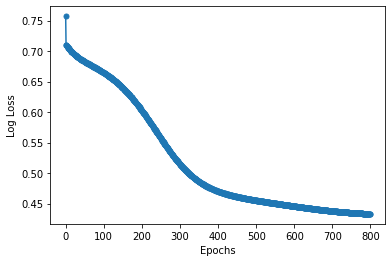

Training accuracy 0.8053
Validation accuracy 0.764


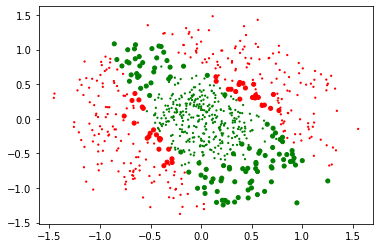

CPU times: user 2.45 s, sys: 234 ms, total: 2.69 s
Wall time: 2.55 s


In [30]:
%%time
network = FeedForwardNetwork(layer_sizes, SigmoidActivator(), softmax, grad_ce_softmax, random)
learning_algo = GradientDescentLearner(network, learning_rate = 0.5)
model = MultiClassifier(network, learning_algo, LossPlotter())
model.fit(X_train, y_OH_train, epochs=800)
print_accuracy(model,True)


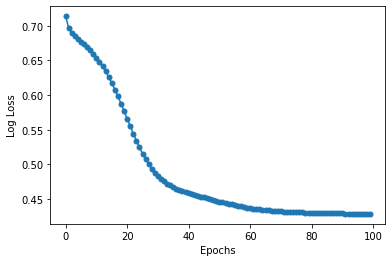

Training accuracy 0.8093
Validation accuracy 0.76


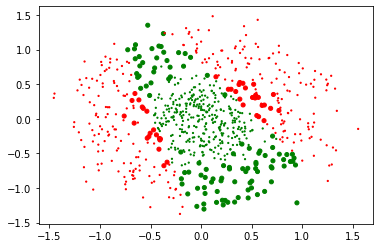

CPU times: user 812 ms, sys: 125 ms, total: 938 ms
Wall time: 828 ms


(None, <function __main__.random(rows, cols)>)

In [31]:
%%time
network = FeedForwardNetwork(layer_sizes, SigmoidActivator(), softmax, grad_ce_softmax, random)
learning_algo = BatchedGradientDescentLearner(network, learning_rate = 1, batch_size = 128)
model = MultiClassifier(network, learning_algo, LossPlotter())
model.fit(X_train, y_OH_train, epochs=100)
print_accuracy(model,True), random


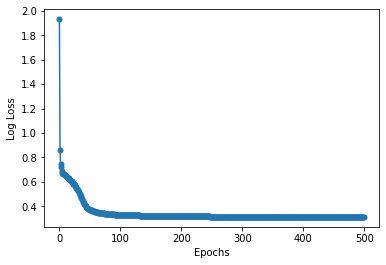

Training accuracy 0.8733
Validation accuracy 0.824


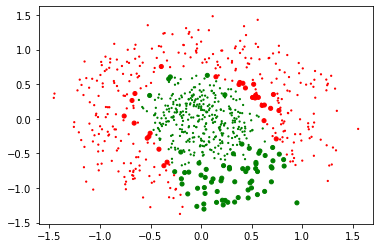

CPU times: user 1.66 s, sys: 93.8 ms, total: 1.75 s
Wall time: 1.67 s


In [32]:
%%time
network = FeedForwardNetwork(layer_sizes, LeakyReluActivator(), softmax, grad_ce_softmax, he)
learning_algo = MomentumGradientDescentLearner(network, learning_rate = 0.4, hist_decay_rate = 0.5)
model = MultiClassifier(network, learning_algo, LossPlotter())
model.fit(X_train, y_OH_train, epochs=500)
print_accuracy(model,True)


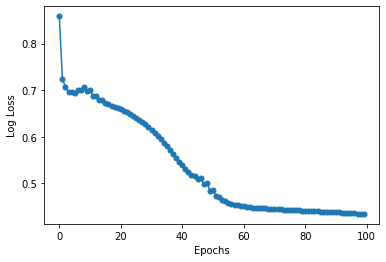

Training accuracy 0.8013
Validation accuracy 0.772


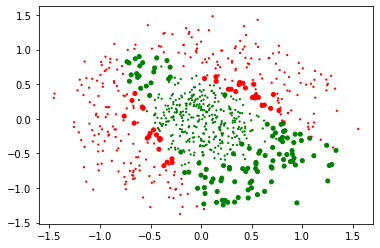

CPU times: user 781 ms, sys: 125 ms, total: 906 ms
Wall time: 780 ms


In [33]:
%%time
network = FeedForwardNetwork(layer_sizes, SigmoidActivator(), softmax, grad_ce_softmax, random)
learning_algo = NagGradientDescentLearner(network, learning_rate = 1, hist_decay_rate = 0.9)
model = MultiClassifier(network, learning_algo, LossPlotter())
model.fit(X_train, y_OH_train, epochs=100)
print_accuracy(model,True)


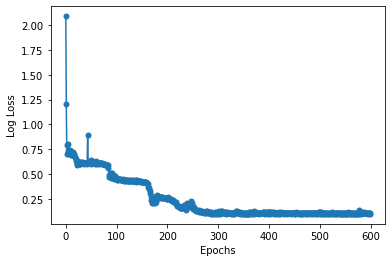

Training accuracy 0.9573
Validation accuracy 0.968


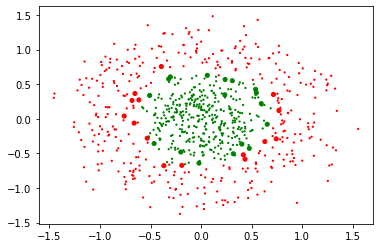

CPU times: user 2.28 s, sys: 156 ms, total: 2.44 s
Wall time: 2.33 s


In [41]:
%%time
network = FeedForwardNetwork(layer_sizes, LeakyReluActivator(), softmax, grad_ce_softmax, he)
learning_algo = AdamGradientDescentLearner(network, learning_rate = 0.4, hist_decay_rate = 0.9,hist_quad_decay=0.9 )
model = MultiClassifier(network, learning_algo, LossPlotter())
model.fit(X_train, y_OH_train, epochs=600)
print_accuracy(model,True)


In [85]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch

In [86]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)

In [87]:
X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))
X_train = X_train.float()
Y_train = Y_train.long()
X_val = X_val.float()
Y_val = Y_val.long()

In [88]:
class FirstNetworkSeq(nn.Module):
  
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.net = nn.Sequential(
        nn.Linear(2, 2), 
        nn.Sigmoid(), 
        nn.Linear(2, 4), 
        nn.Softmax(dim = -1)
        )

    def forward(self, X):
        return self.net(X)

In [89]:
def fit(x, y, model, opt, loss_fn, epochs = 1000):
    
    Y_Pred_train = []
  
    for epoch in range(epochs):
        pred_train = model(x)
        Y_Pred_train.append(pred_train)
        loss = loss_fn(pred_train, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return Y_Pred_train

In [93]:
def val_accuracy(x,y, model):
    Y_pred_val = model(x)
    print(accuracy(Y_pred_val, Y_val))

In [91]:
def accuracy(y_hat, y):
  pred = torch.argmax(y_hat, dim=1)
  return (pred == y).float().mean()

In [148]:
fn = FirstNetworkSeq()
loss_fn = F.cross_entropy
opt = optim.SGD(fn.parameters(), lr=1)
Y_pred_train = fit(X_train, Y_train, fn, opt, loss_fn)
print(accuracy(Y_pred_train[-1], Y_train))
val_accuracy(X_val, Y_val, fn)

tensor(0.8867)
tensor(0.8880)


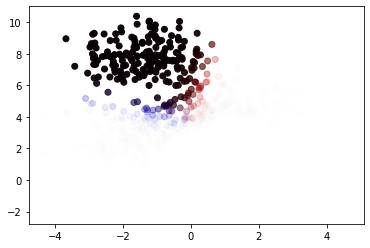

In [149]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train[-1].detach().numpy(), cmap=ryg_cmap)
plt.show()